In [62]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 获取当前目录
current_dir = os.getcwd()  

# 添加 `interClusLib` 的上级目录到 Python 路径
sys.path.append(os.path.join(current_dir, ".."))

import interClusLib
from interClusLib.IntervalData import IntervalData
from interClusLib.metric import *
from interClusLib.visualization.Interval3d import Interval3d
from interClusLib.clustering.IntervalKMeans import IntervalKMeans


print("interClusLib Path:", interClusLib.__file__)

random_data = IntervalData.make_interval_blobs(n_samples = 100, n_dims=3 ,n_clusters = 5)
print("\n Random Interval Data:")
print(random_data.data)
random_data.summary()

interClusLib Path: /Users/jiashuchen/Desktop/InterClusLib/examples/../interClusLib/__init__.py

 Random Interval Data:
    feature_1_lower  feature_1_upper  feature_2_lower  feature_2_upper  \
0        -10.895486        -7.869998         4.212467         6.717001   
1         -4.348937        -1.077743        -5.366036        -5.266036   
2          6.493290         7.278728        -7.151176        -7.051176   
3          6.822978         8.261899        -7.997238        -6.178760   
4          9.185258        10.878654        -7.489223        -6.387186   
..              ...              ...              ...              ...   
95        -6.331035        -2.664128        -6.743623        -6.643623   
96         6.838094         8.715697        -7.751292        -7.651292   
97         4.698072         9.232297        -7.984849        -6.679693   
98         7.848551         9.499880        -9.291159        -9.191159   
99        -9.979636        -5.797540         4.301524         7.201

In [63]:
def plot_intervals_3D(intervals, labels=None):
    fig= plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111,projection='3d')
    Interval3d.draw_3d_interval_cubes(ax, intervals, labels)

    xs = intervals[:, 0, :].ravel()  # x_lower, x_upper
    ys = intervals[:, 1, :].ravel()  # y_lower, y_upper
    zs = intervals[:, 2, :].ravel()  # z_lower, z_upper

    x_min, x_max = xs.min() - 5, xs.max() + 5
    y_min, y_max = ys.min() - 5, ys.max() + 5
    z_min, z_max = zs.min() - 5, zs.max() + 5

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    ax.set_title("3D")

    plt.show()

def plot_intervals_as_squares(intervals, labels=None):
    fig, ax = plt.subplots(figsize=(6,6))
    Interval2d.draw_interval_squares(ax, intervals, labels)

    min_val = intervals.min() - 1
    max_val = intervals.max() + 1
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal', 'box')
    
    ax.set_xlabel("Coordinate X (lower →)")
    ax.set_ylabel("Coordinate Y (lower →)")
    ax.set_title("1D Intervals as Squares")
    plt.show()

def plot_2d_intervals(intervals, labels=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    Interval2d.draw_interval_rectangles(ax, intervals, labels=labels)
    
    # 根据 intervals 范围调整坐标
    x_vals = intervals[:, 0, :].ravel()  # 所有 x_lower, x_upper
    y_vals = intervals[:, 1, :].ravel()  # 所有 y_lower, y_upper
    x_min, x_max = x_vals.min() - 1, x_vals.max() + 1
    y_min, y_max = y_vals.min() - 1, y_vals.max() + 1
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # 让坐标系的 x,y 单位看起来相等
    ax.set_aspect('equal', 'box')
    
    ax.set_xlabel("X dimension")
    ax.set_ylabel("Y dimension")
    ax.set_title("2D Interval Rectangles")
    plt.show()

    

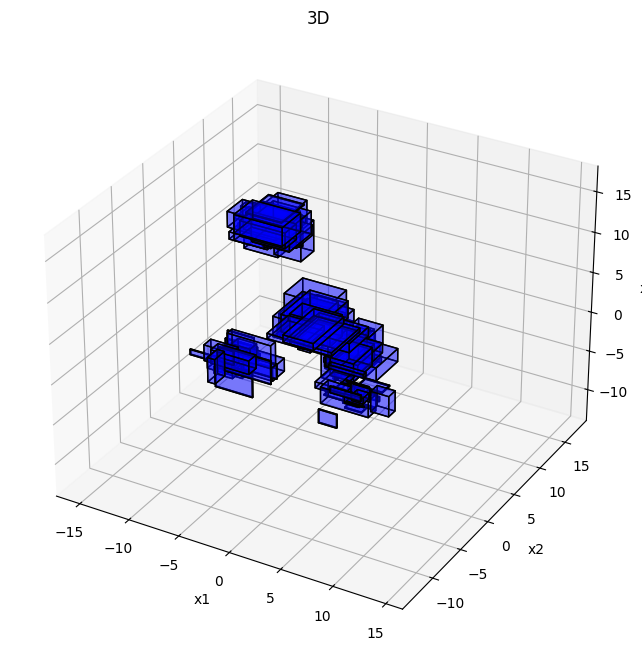

In [64]:
plot_intervals_3D(random_data.get_intervals())

/Users/jiashuchen/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiashuchen/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiashuchen/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiashuchen/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiashuchen/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyp

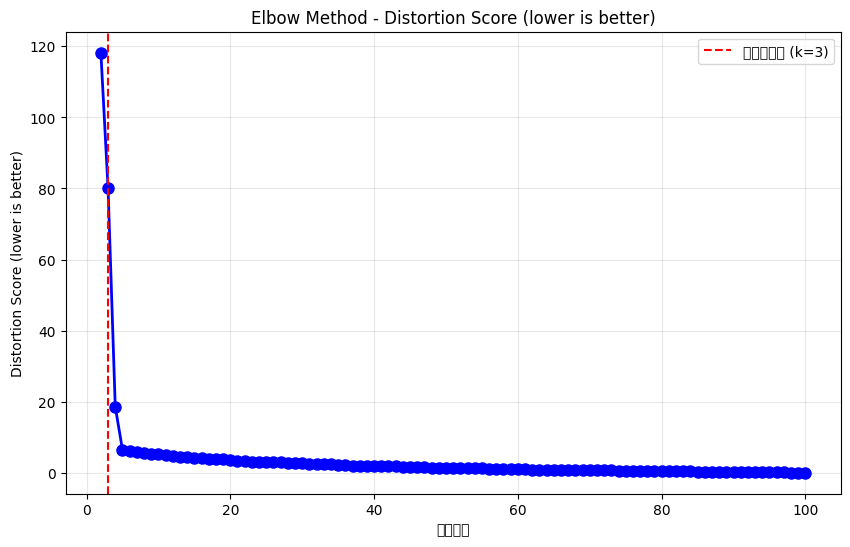

最佳聚类数量: 3
[2 0 1 1 1 2 2 2 0 2 1 0 0 2 2 2 2 0 2 0 2 2 1 0 0 0 1 2 0 1 2 0 2 0 0 0 2
 1 1 0 1 2 2 2 0 2 2 1 1 0 0 0 2 0 2 0 0 1 0 2 0 0 0 1 2 0 0 0 0 2 0 0 1 0
 1 0 2 2 2 2 2 1 2 0 2 2 0 2 2 0 2 0 2 2 0 0 1 1 1 2]


In [65]:
# 初始化模型
model = IntervalKMeans(n_clusters=2, distance_func='euclidean')

# 找到最佳聚类数量
optimal_k, eval_results = model.find_optimal_clusters(
    random_data.get_intervals(),
    min_clusters=2,
    max_clusters=100,
    method='elbow',
    eval_metric='distortion'
)

print(f"最佳聚类数量: {optimal_k}")

# 使用最佳聚类数量训练最终模型
final_model = IntervalKMeans(n_clusters= optimal_k, distance_func='euclidean')
final_model.fit(random_data.get_intervals())

print(final_model.labels_)

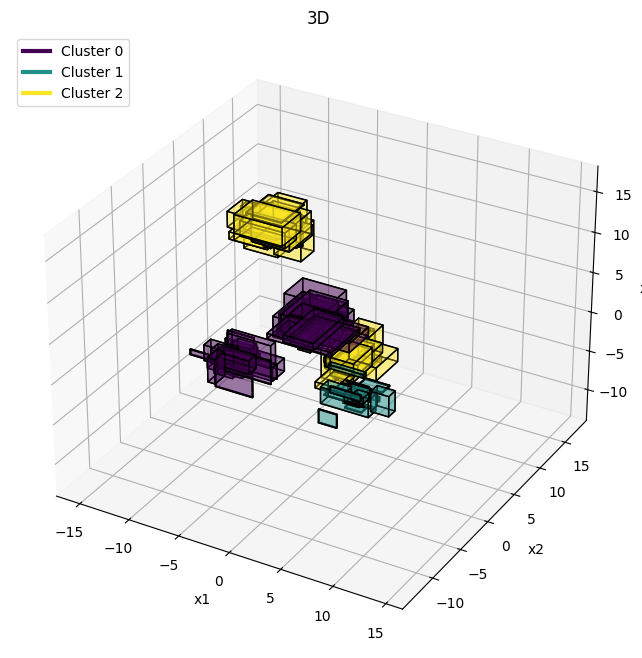

In [66]:
plot_intervals_3D(random_data.get_intervals(), final_model.labels_)